In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
from itertools import combinations
from math import ceil, factorial as f
from tqdm.notebook import tqdm
nCr = lambda n, r: f(n) // f(r) // f(n-r)

In [2]:
# Round 1
lst = ['stats_'+i+'.csv' for i in [
    'control','adagrad','batch','layer','node','price','rb','step'
]]
# Round 2
lst2 = ['stats_node_'+i+'.csv' for i in [
    '4','price','rb', 'step', 'batch'
]]
# Round 3
lst3 = ['stats_node_'+i+'.csv' for i in [
    '4_800i', '4_200i', '8', '16'
]]

In [3]:
# Reorganise data
df = {}
for i in lst+lst2+lst3:
    df[i.split('.')[0]] = pd.read_csv(i)
    df[i.split('.')[0]]['sharpe'] = (
        df[i.split('.')[0]]['mean']-1
    )/df[i.split('.')[0]]['std']
df2 = {}
for k in ['median', 'sharpe']:#df[lst[0].split('.')[0]].columns:
    df2[k] = pd.concat([j[k].rename('_'.join(i.split('_')[1:])) for i,j in df.items()], axis=1)

In [4]:
# Benchmark (policy is holding risky asset till end of period)
base_price = pd.read_csv('sim_price.csv').iloc[-1]
base_median = np.median(base_price)
base_sharpe = (base_price.mean()-1)/base_price.std()
print('Median is {:.2f}, Sharpe ratio is {:.2f}.'.format(
    base_median, base_sharpe
))

Median is 1.41, Sharpe ratio is 0.96.


In [5]:
# Rename the lists for tagging
lst  = ['_'.join(i.split('.')[0].split('_')[1:]) for i in lst]
lst2 = ['_'.join(i.split('.')[0].split('_')[1:]) for i in lst2]
lst3 = ['_'.join(i.split('.')[0].split('_')[1:]) for i in lst3]

## Boxplot for Single Modifiers

In [6]:
def boxplot(df, key, show_outliers=True, lst=None, figsize=(16,8)):
    return df[key].boxplot(figsize=figsize, showfliers=show_outliers) if lst is None \
           else df[key][lst].boxplot(figsize=figsize, showfliers=show_outliers)

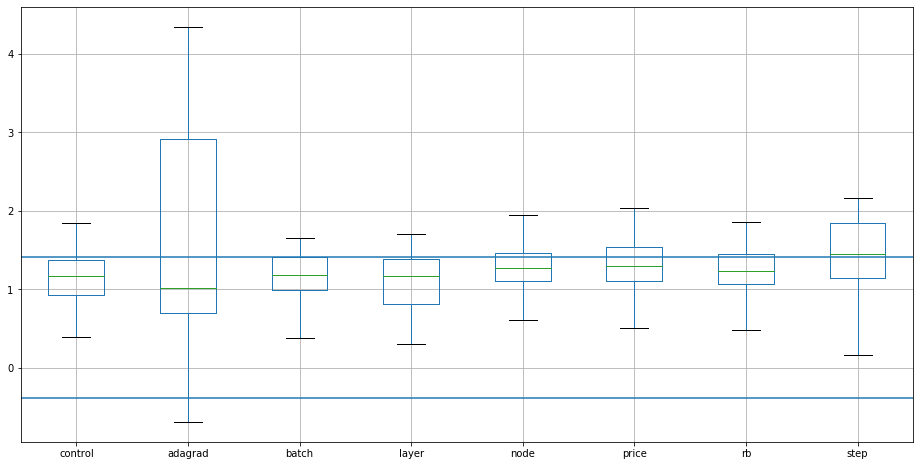

In [7]:
boxplot(df2, 'median', False, lst)
plt.axhline(base_median)
plt.axhline(-0.390)

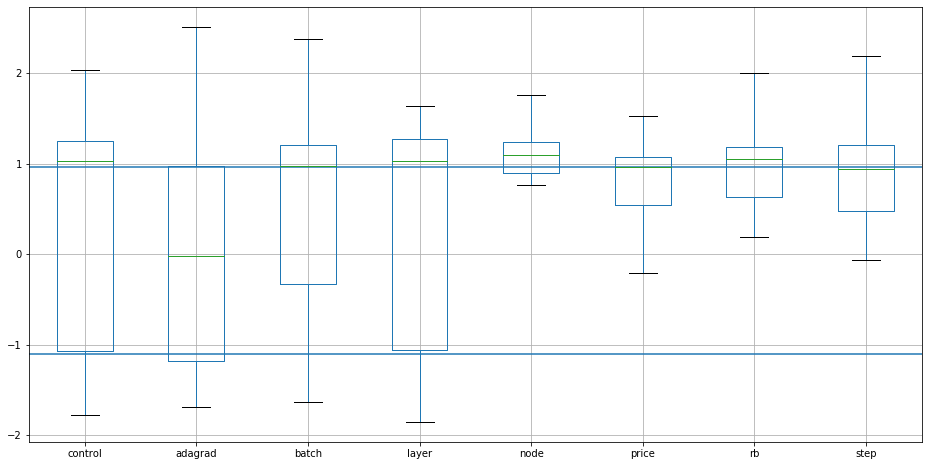

In [8]:
boxplot(df2, 'sharpe', False, lst)
plt.axhline(base_sharpe)
plt.axhline(-1.107)

## Kernel Density Estimator to Visualise Significance

In [9]:
create_sample_dist = lambda df, key, variable, dist_size=50, frac=0.2:\
    pd.Series([
    df[key][variable].sample(frac=frac).mean()
    for _ in range(dist_size)
], name=variable)

def filter_outliers_melt(df, key):
    desc = df[key].describe()
    pct_25, pct_75 = desc.loc['25%'], desc.loc['75%']
    pct_25, pct_75 = 2.5*pct_25 - 1.5*pct_75, 2.5*pct_75 - 1.5*pct_25
    filtered_df = df[key][df[key] < pct_75]
    filtered_df = filtered_df[filtered_df > pct_25]
    filtered_df = filtered_df.melt().dropna()
    filtered_df.columns = ['variable', key]
    return filtered_df

def create_sample_dist_filtered(
    df, key, variable, dist_size=50, frac=0.2
): 
    filtered_df = filter_outliers_melt(df, key)
    return pd.Series(
        [filtered_df[filtered_df.variable==variable][key].sample(frac=frac).mean() 
         for _ in range(dist_size)],
        name=variable
    )

In [10]:
df3 = {key: pd.concat([
    create_sample_dist_filtered(df2, key, variable, 1000, 0.5)
    for variable in lst+lst2+lst3
], axis=1) for key in tqdm(
    ['median', 'sharpe'], leave=False
)}

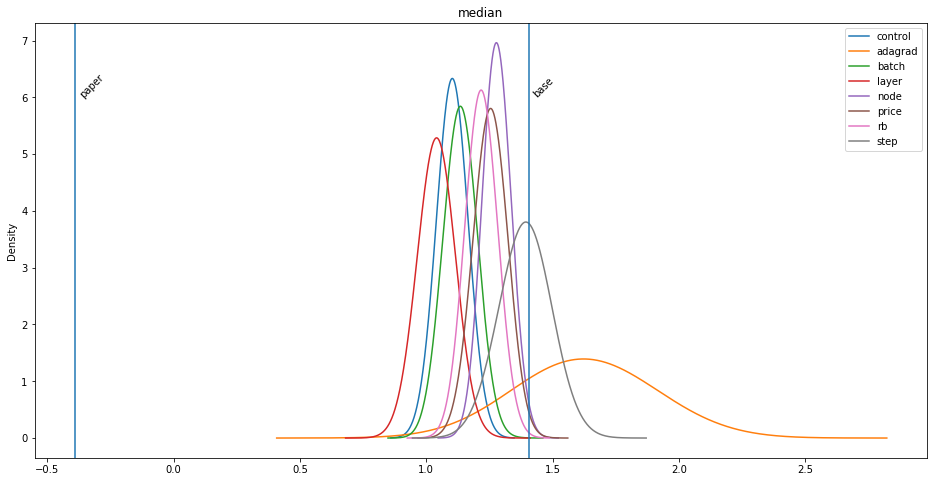

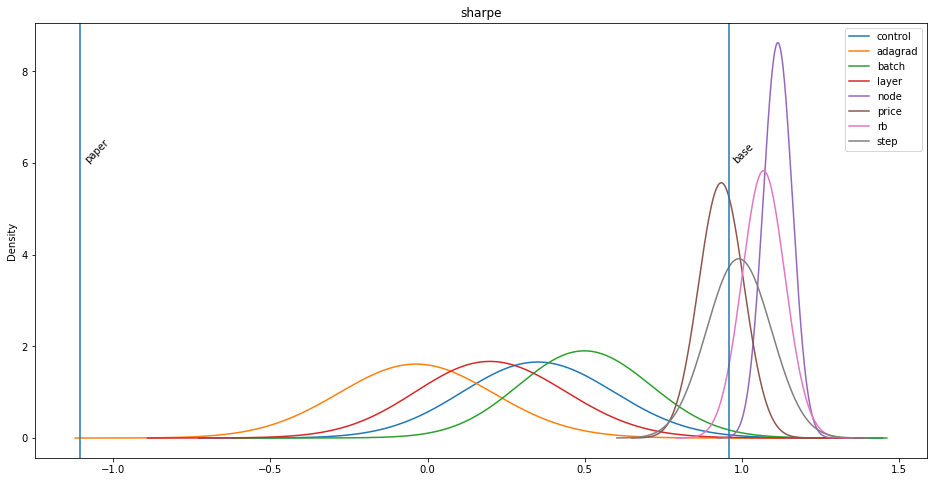

In [11]:
for key, base, paper in zip(df3.keys(), [base_median, base_sharpe], [-0.390, -1.107]):
    df3[key][lst].plot.kde(bw_method=1, figsize=(16,8), title=key)
    plt.axvline(base)
    plt.text(base+0.01, 6, 'base', rotation=45)
    plt.axvline(paper, label='paper')
    plt.text(paper+0.01, 6, 'paper', rotation=45)


In [12]:
pd.Series({variable: stats.ttest_ind(
    df3['median']['control'],
    df3['median'][variable],
    equal_var=False
).pvalue for variable in ['batch', 'rb', 'price', 'node','step', 'adagrad']})

batch      5.392348e-52
rb         0.000000e+00
price      0.000000e+00
node       0.000000e+00
step       0.000000e+00
adagrad    0.000000e+00
dtype: float64

In [13]:
pd.Series({variable: stats.ttest_ind(
    df3['sharpe']['control'],
    df3['sharpe'][variable],
    equal_var=False
).pvalue for variable in ['batch', 'price', 'step', 'rb', 'node']})

batch    9.832675e-87
price    0.000000e+00
step     0.000000e+00
rb       0.000000e+00
node     0.000000e+00
dtype: float64

Doubling of nodes is the winner, doubling of batch, use of price and step, 10x of replay buffer are viable to use in conjunction with node doubling.

## 2nd Round

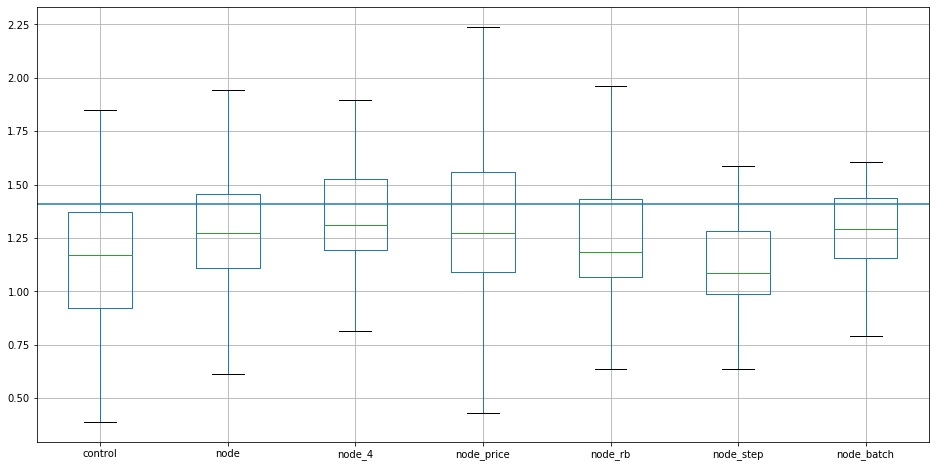

In [14]:
boxplot(df2, 'median', False, ['control', 'node']+lst2)
plt.axhline(base_median)

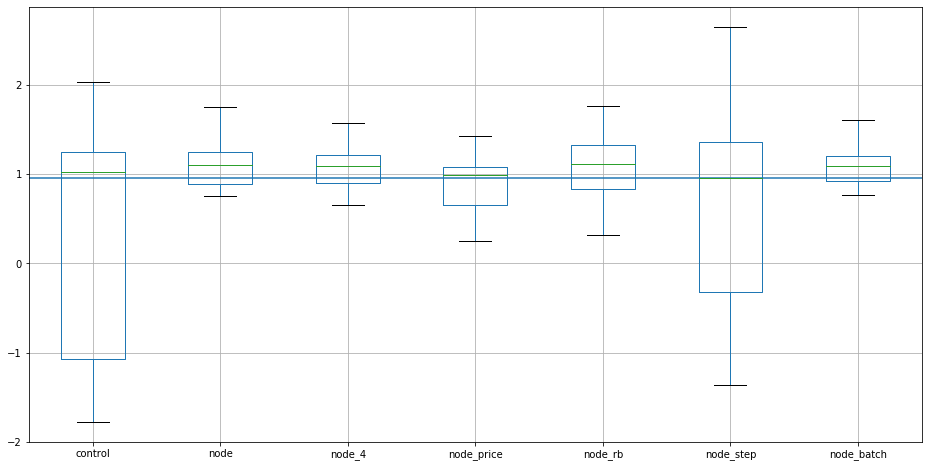

In [15]:
boxplot(df2, 'sharpe', False, ['control', 'node']+lst2)
plt.axhline(base_sharpe)

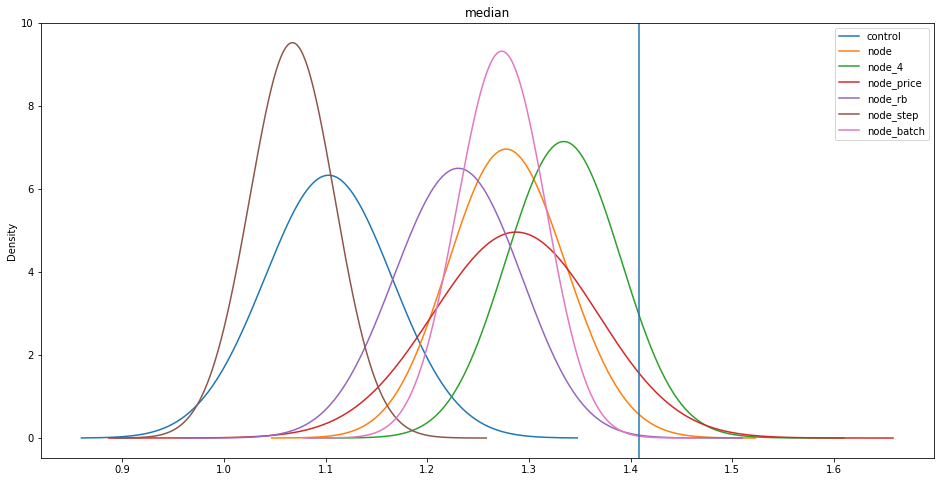

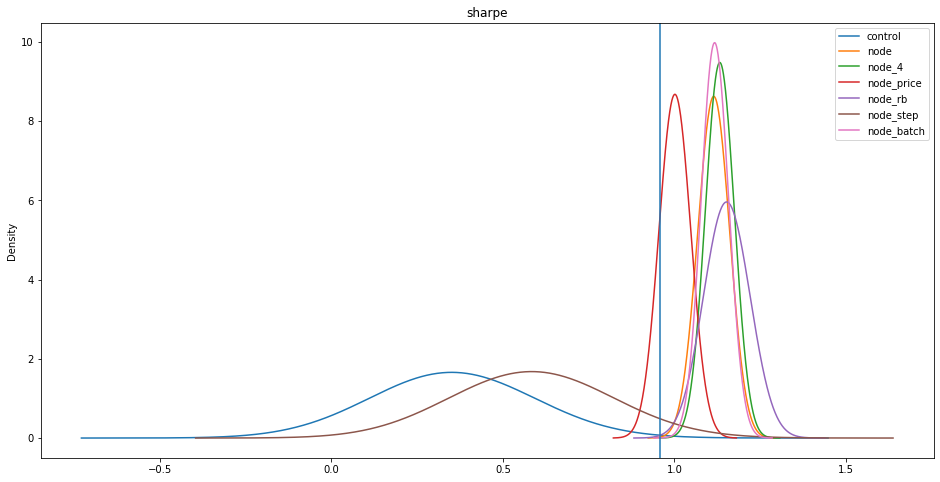

In [16]:
for key, base in zip(df3.keys(), [base_median, base_sharpe]):
    df3[key][['control', 'node']+lst2].plot.kde(bw_method=1, figsize=(16,8), title=key)
    plt.axvline(base, label='base')

In [17]:
pd.Series({variable: stats.ttest_ind(
    df3['median']['node'],
    df3['median']['node_' + variable],
    equal_var=False
).pvalue for variable in ['4', 'price']})

4        5.922341e-172
price     2.863192e-03
dtype: float64

In [18]:
pd.Series({variable: stats.ttest_ind(
    df3['sharpe']['node'],
    df3['sharpe']['node_' + variable],
    equal_var=False
).pvalue for variable in ['4', 'rb']})

4     1.287890e-36
rb    1.090141e-90
dtype: float64

## 3rd Round

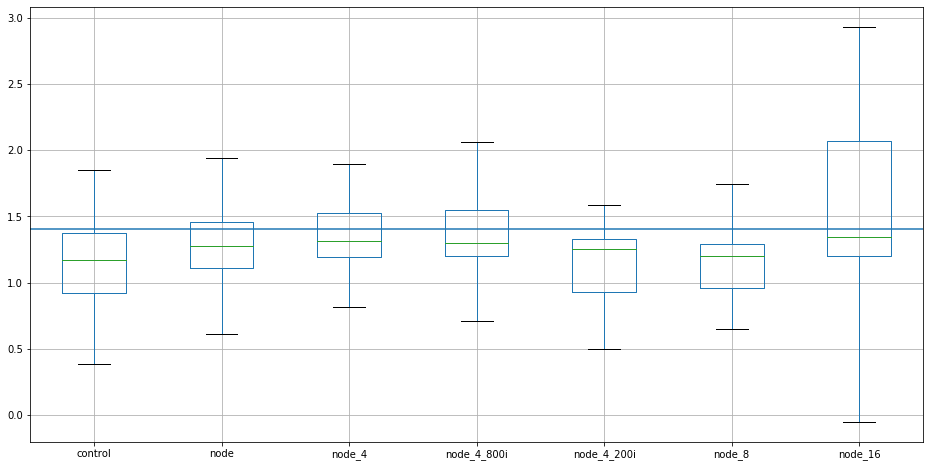

In [19]:
boxplot(df2, 'median', False, ['control', 'node', 'node_4']+lst3)
plt.axhline(base_median)

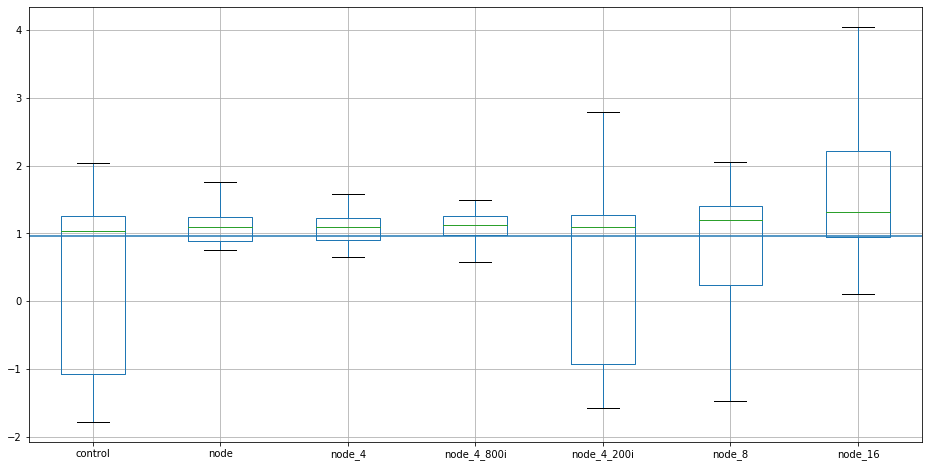

In [20]:
boxplot(df2, 'sharpe', False, ['control', 'node', 'node_4']+lst3)
plt.axhline(base_sharpe)

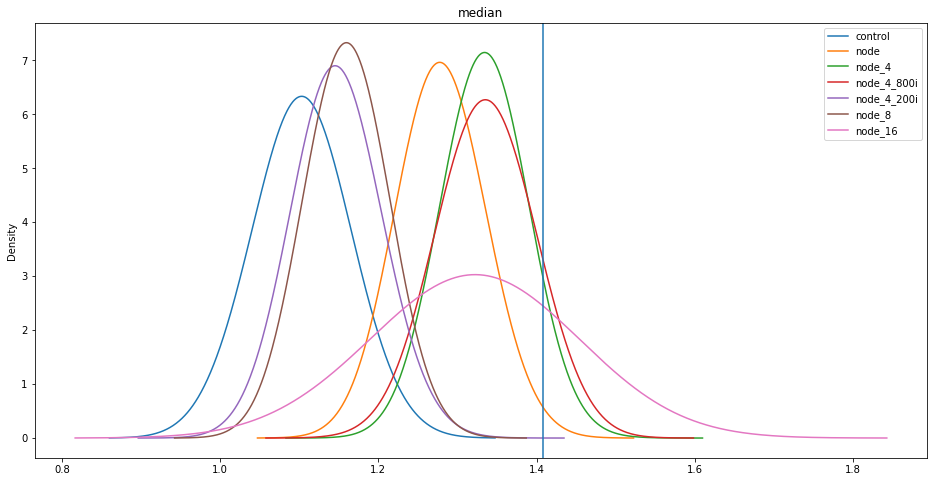

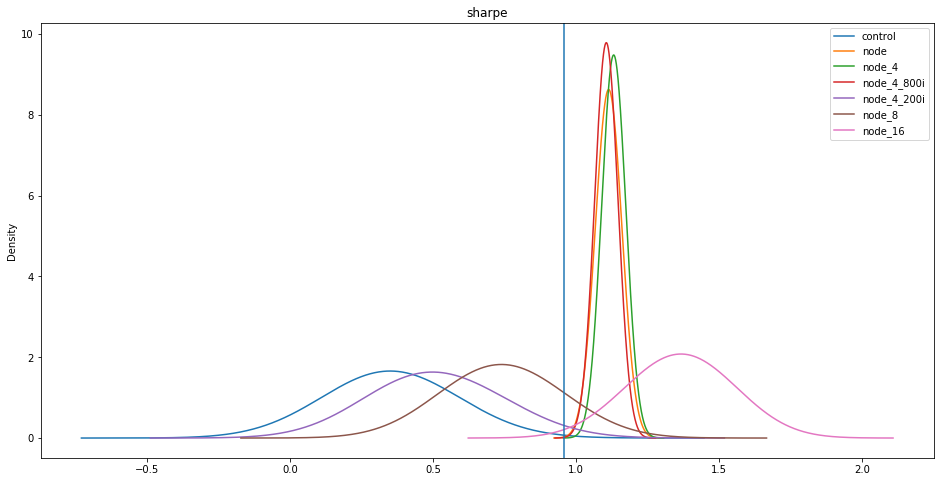

In [21]:
for key, base in zip(df3.keys(), [base_median, base_sharpe]):
    df3[key][['control', 'node', 'node_4']+lst3].plot.kde(bw_method=1, figsize=(16,8), title=key)
    plt.axvline(base, label='base')

In [22]:
df3['median']['node_16'].median()-df3['median']['node_4'].median()

-0.014436766017405844

In [23]:
pd.Series({variable: stats.ttest_ind(
    df3['median']['node_4'],
    df3['median']['node_' + variable],
    equal_var=False
).pvalue for variable in ['4_800i']})

4_800i    0.516463
dtype: float64

In [24]:
pd.Series({variable: stats.ttest_ind(
    df3['sharpe']['node_4'],
    df3['sharpe']['node_' + variable],
    equal_var=False
).pvalue for variable in ['16', '4_800i']})

16        2.069616e-311
4_800i     4.368321e-80
dtype: float64